In [1]:
from keras.models import load_model
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-25 12:23:27.323147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/SimpleExampleKerasModel.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-14 11:47:17.296029: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9686 - loss: 0.1093
Test Accuracy: 0.9766
Test Loss: 0.0810


In [4]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [5]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 70502 predictions greater then 0.5

70084 predictions are greater then 0.6
That is 99.4 percent of all predictions greater then 0.5

69620 predictions are greater then 0.7
That is 98.7 percent of all predictions greater then 0.5

68883 predictions are greater then 0.8
That is 97.7 percent of all predictions greater then 0.5

67389 predictions are greater then 0.9
That is 95.6 percent of all predictions greater then 0.5

65532 predictions are greater then 0.95
That is 93.0 percent of all predictions greater then 0.5

62544 predictions are greater then 0.98
That is 88.7 percent of all predictions greater then 0.5


In [6]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 19498 predictions less then 0.5

19095 predictions are smaller then 0.4
That is 97.9 percent of all predictions smaller then 0.5

18757 predictions are smaller then 0.3
That is 96.2 percent of all predictions smaller then 0.5

18378 predictions are smaller then 0.2
That is 94.3 percent of all predictions smaller then 0.5

17772 predictions are smaller then 0.1
That is 91.1 percent of all predictions smaller then 0.5

17131 predictions are smaller then 0.05
That is 87.9 percent of all predictions smaller then 0.5

16191 predictions are smaller then 0.02
That is 83.0 percent of all predictions smaller then 0.5


In [7]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.96      0.93      0.95     20000
    ImageNet       0.98      0.99      0.98     70000

    accuracy                           0.98     90000
   macro avg       0.97      0.96      0.97     90000
weighted avg       0.98      0.98      0.98     90000



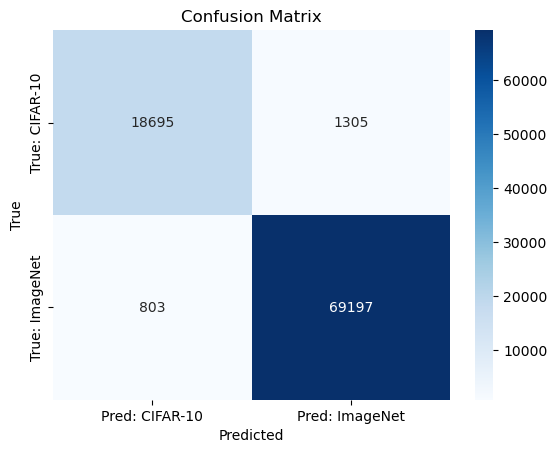

In [8]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [10]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten()
})

In [11]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [12]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index    category  y_true    prediction
7    9522  automobile       0  2.574329e-06
16   1170    airplane       0  8.209022e-08
17  36521        deer       0  2.934273e-08
20  72951        ship       0  1.834638e-04
22  72820        ship       0  2.448231e-06
   index    category  y_true  prediction
0  26867        bird       1    0.999750
1  12519  automobile       1    0.995053
2  88404       truck       1    0.999822
3  75942        ship       1    0.992516
4  52544         dog       1    0.999999


In [13]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [14]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

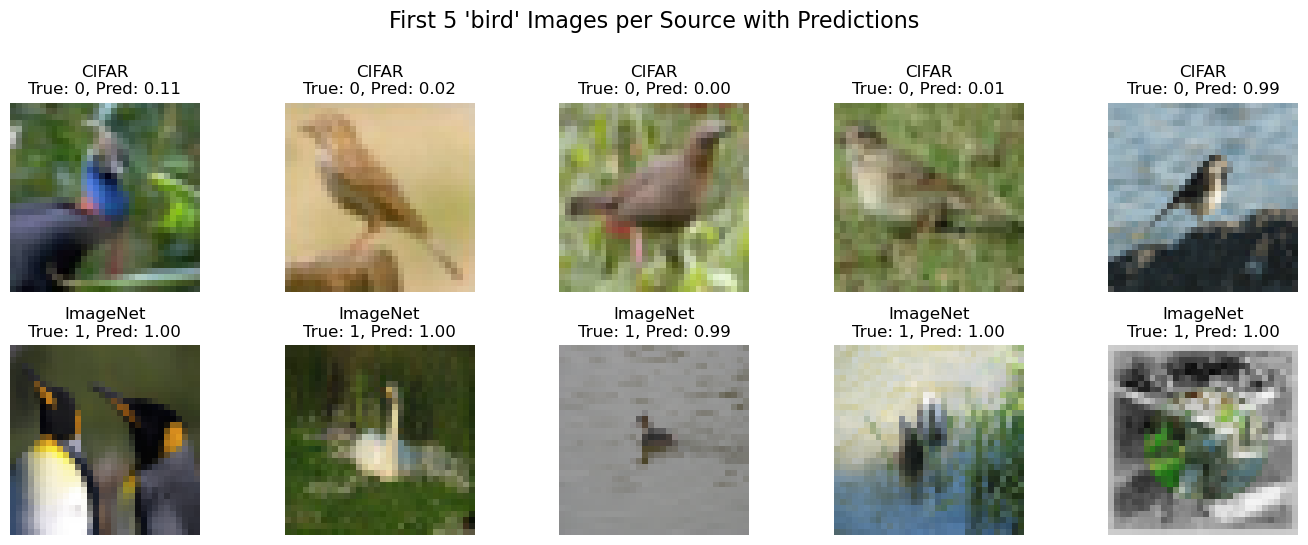

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
category = "bird"

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][:5])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][:5])

# CIFAR-10 (top row)
for i in range(5):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(5):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,933 (1.91 MB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 333,956 (1.27 MB)

In [17]:
layer = model.layers[0] # layer.name returns 'conv2d'

# Extract weights from the Conv2D layer
kernels, biases = layer.get_weights()  # shape: (3, 3, 3, 32) for a 3x3 RGB kernel, 32 filters
print("Kernel shape:", kernels.shape)
print(layer.input)

Kernel shape: (3, 3, 3, 32)
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>


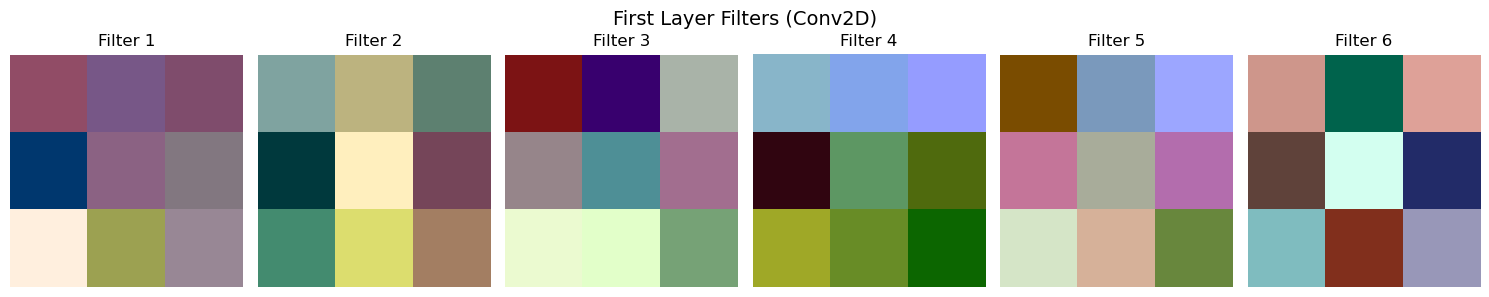

In [18]:
# Choose the first few filters
n_filters_to_show = 6
fig, axs = plt.subplots(1, n_filters_to_show, figsize=(15, 3))

for i in range(n_filters_to_show):
    # Normalize for visualization
    kernel = kernels[:, :, :, i]
    kernel_min, kernel_max = kernel.min(), kernel.max()
    kernel_vis = (kernel - kernel_min) / (kernel_max - kernel_min)

    axs[i].imshow(kernel_vis)
    axs[i].set_title(f"Filter {i+1}")
    axs[i].axis('off')

plt.suptitle("First Layer Filters (Conv2D)", fontsize=14)
plt.tight_layout()
plt.show()


In [22]:
def visualize_activations(model, image, max_filters=6):
    """
    Visualize intermediate activations after each layer for a single image.

    Parameters:
    - model: Trained Keras model
    - image: Numpy array of shape (32, 32, 3)
    - max_filters: How many filters to display per conv layer
    """
    # Show original image
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()
    
    # Prepare image as batch input
    img_input = np.expand_dims(image, axis=0)

    # Get intermediate outputs
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(img_input)

    # Visualize outputs
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Conv/Pool layers: (1, H, W, C)
            num_filters = min(activation.shape[-1], max_filters)
            fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2.5, 2.5))
            for j in range(num_filters):
                axs[j].imshow(activation[0, :, :, j], cmap='viridis')
                axs[j].axis('off')
                axs[j].set_title(f"Filter {j}")
            plt.suptitle(f"Layer {i}: {model.layers[i].name} → shape {activation.shape[1:]}", fontsize=12)
            plt.tight_layout()
            plt.show()
        elif len(activation.shape) == 2:  # Dense layer: (1, N)
            print(f"Layer {i}: {model.layers[i].name} → Dense output shape: {activation.shape}")
            print(f"Output values (first 10): {activation[0][:36]}")


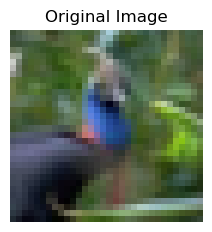

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


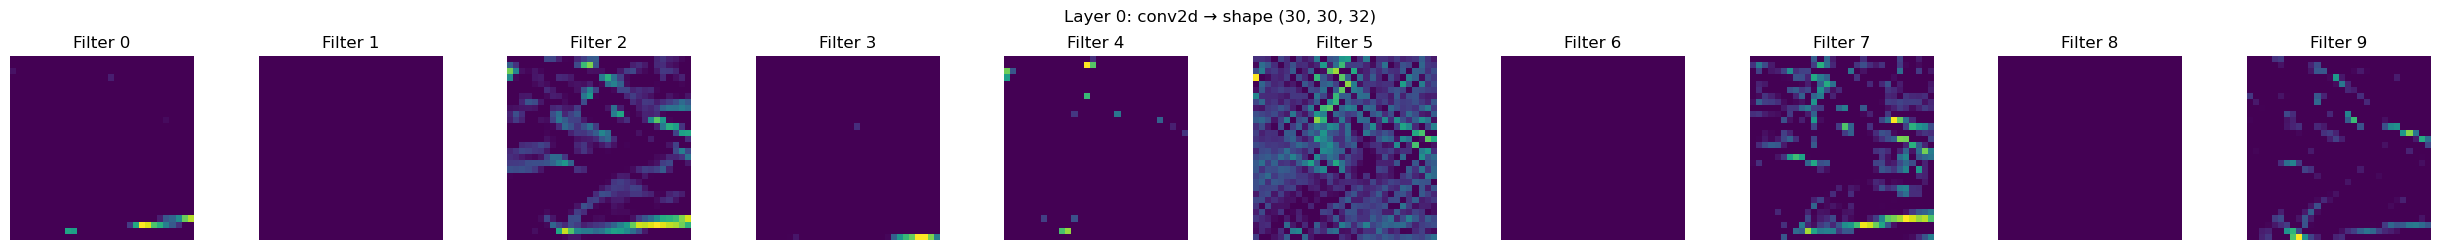

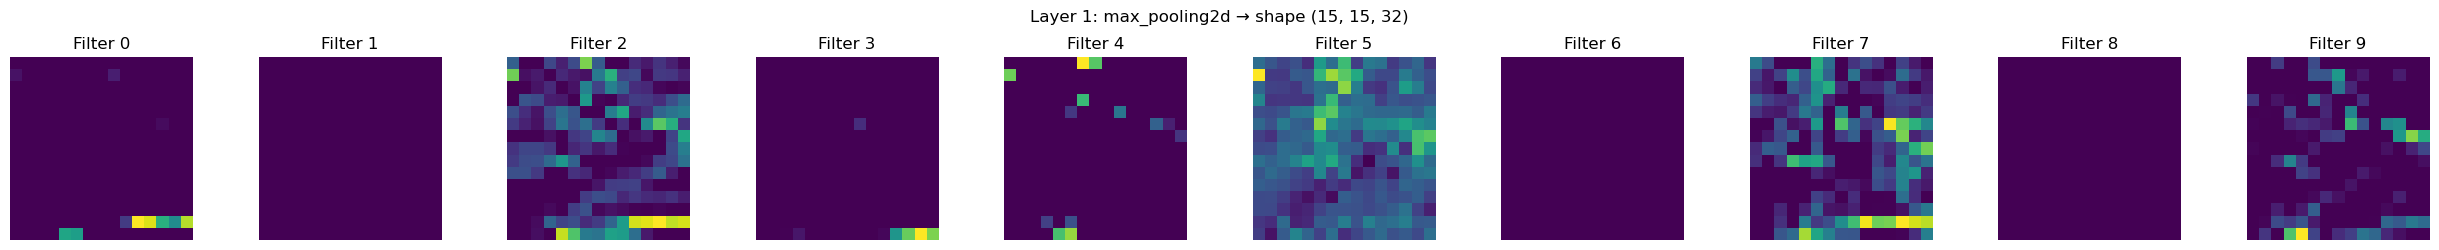

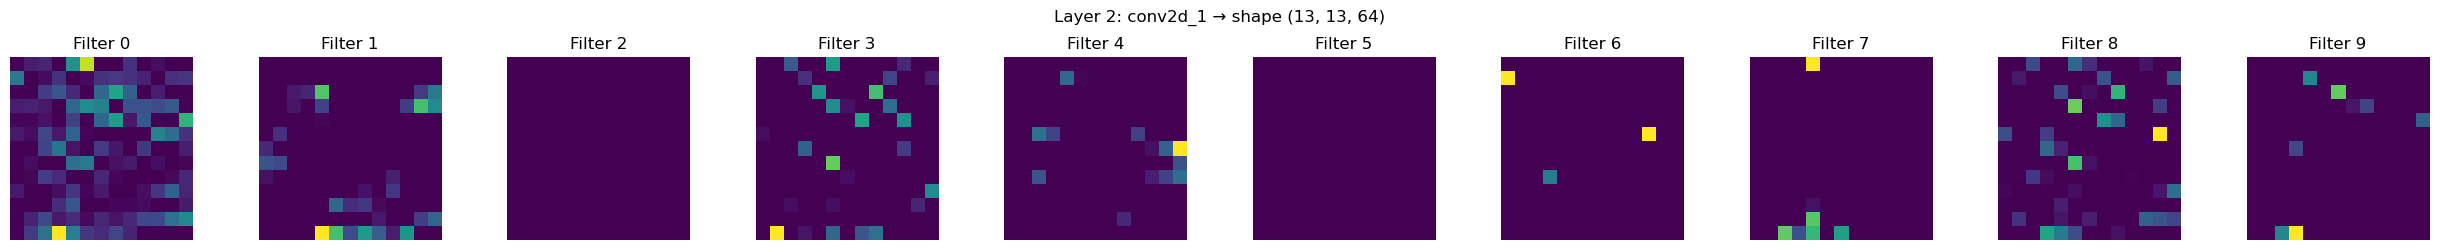

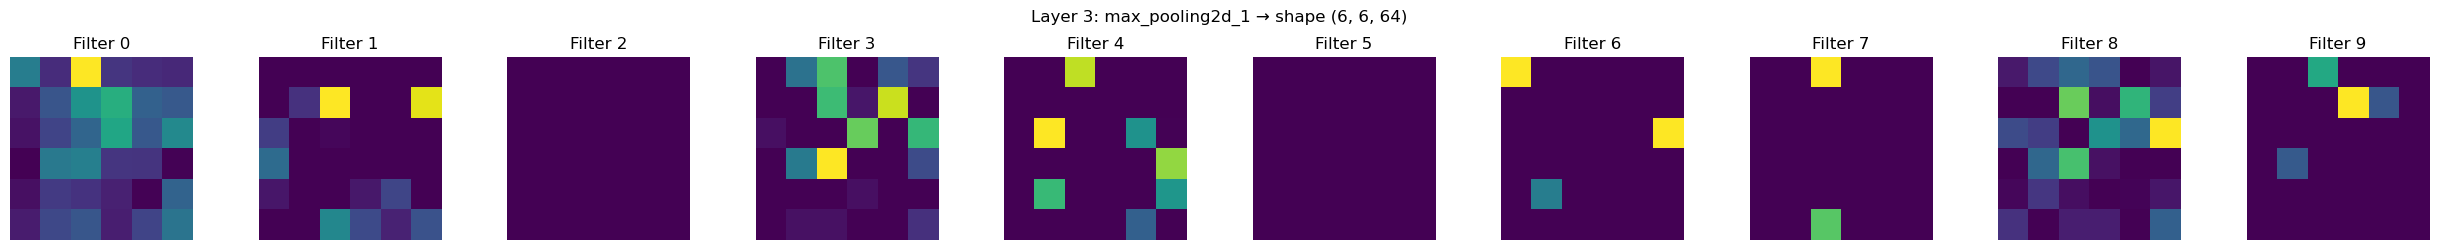

Layer 4: flatten → Dense output shape: (1, 2304)
Output values (first 10): [0.20291737 0.         0.         0.         0.         0.
 0.02186798 0.         0.01594925 0.         0.02778171 0.
 0.         0.         0.         0.16028765 0.         0.2518396
 0.         0.         0.         0.         0.         0.
 0.         0.05917718 0.05791973 0.         0.16589062 0.
 0.         0.03817812 0.         0.         0.         0.        ]
Layer 5: dense → Dense output shape: (1, 64)
Output values (first 10): [0.546668   0.         0.         0.31960052 0.         0.
 0.57339835 1.573619   0.         0.         0.         0.
 0.         0.49546298 0.49590337 0.         0.43297416 0.9404924
 0.5170091  1.1502765  0.         0.         0.         0.49295682
 0.409426   0.46255568 0.         0.12806442 0.         0.
 0.         0.54957265 0.40341038 0.44044518 0.         0.        ]
Layer 6: dense_1 → Dense output shape: (1, 1)
Output values (first 10): [0.11067442]


In [23]:
img = cifar_images[0]
visualize_activations(model, img, max_filters=10)

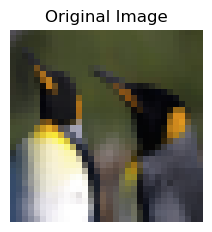

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


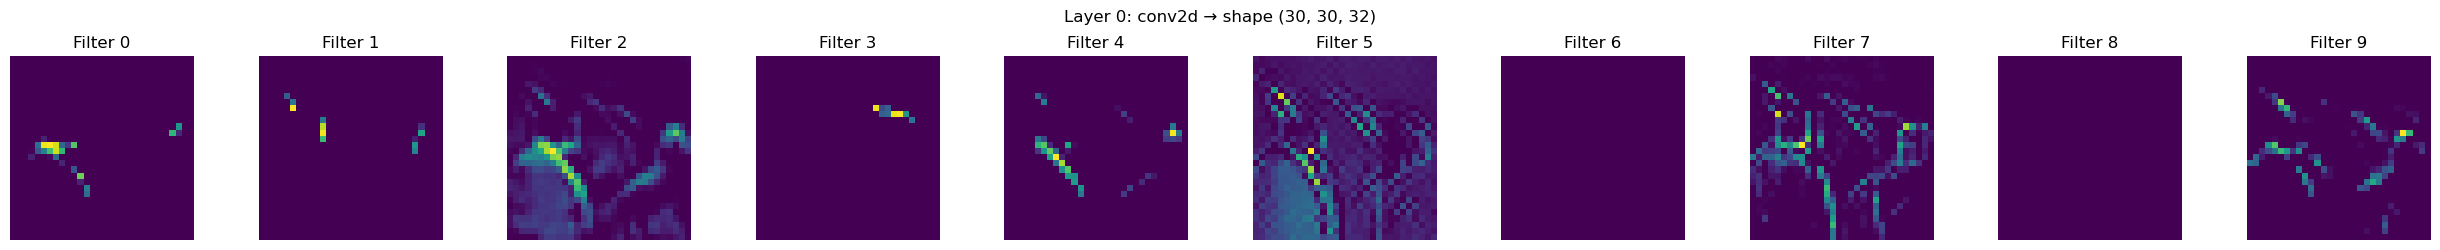

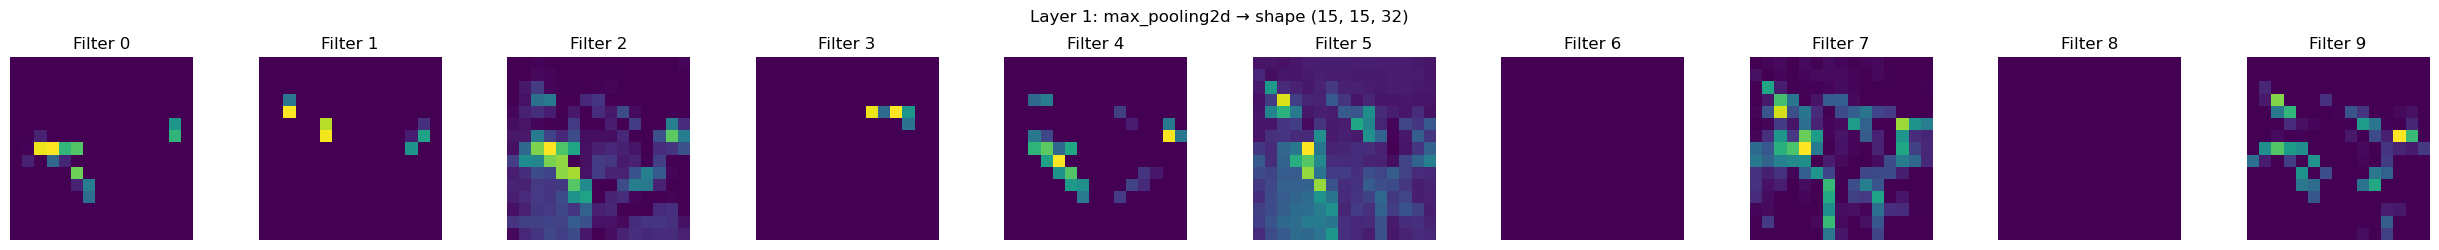

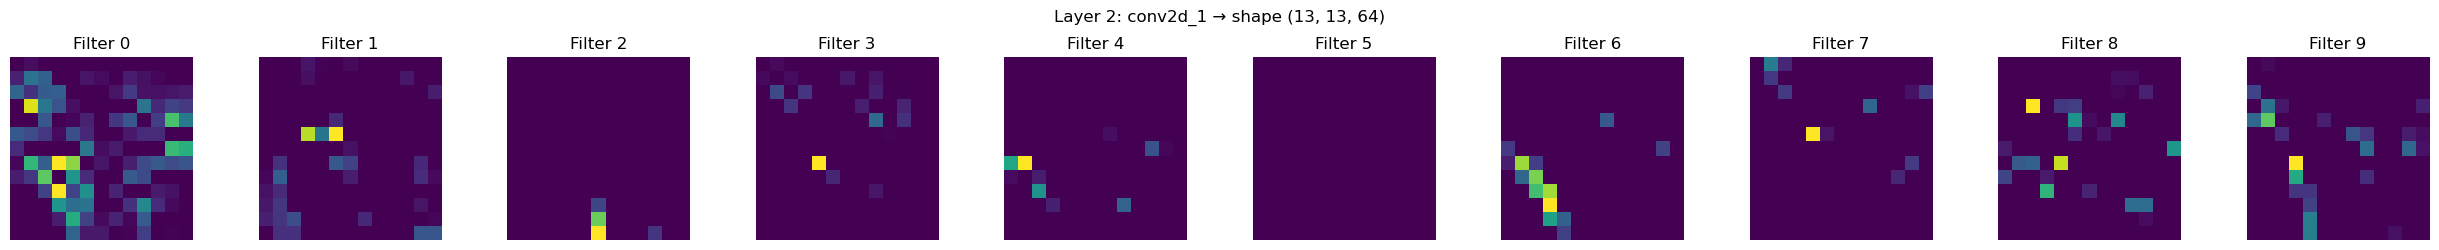

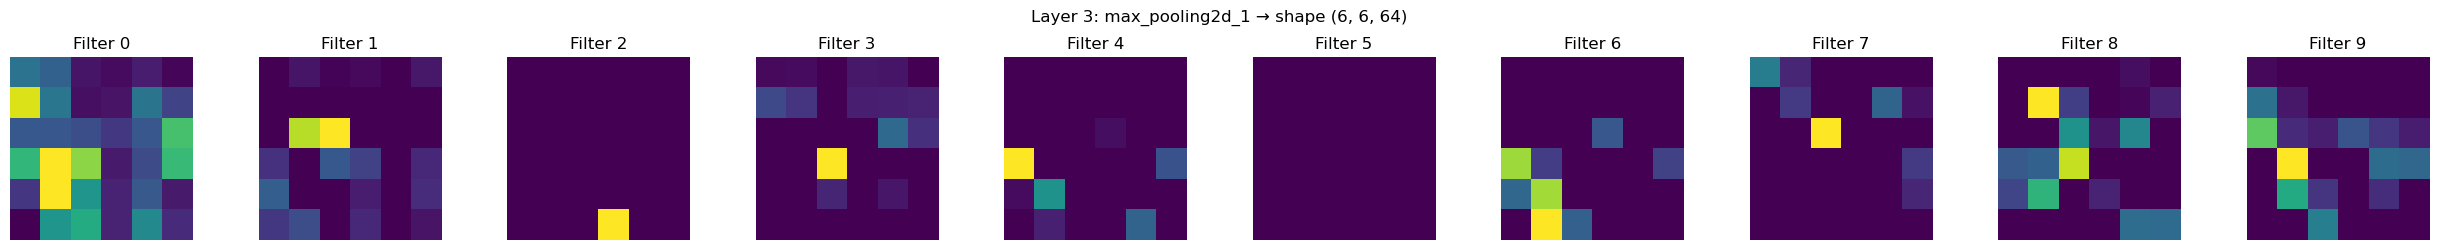

Layer 4: flatten → Dense output shape: (1, 2304)
Output values (first 10): [2.06606835e-01 3.96881718e-04 0.00000000e+00 1.30201969e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.92896950e-02
 0.00000000e+00 7.97905028e-03 0.00000000e+00 2.69852784e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00018516e-01 2.63357759e-02 3.15087318e-01
 2.46349216e-01 0.00000000e+00 0.00000000e+00 4.08862978e-01
 0.00000000e+00 1.38769895e-01 0.00000000e+00 4.64400530e-01
 0.00000000e+00 0.00000000e+00 2.49011755e-01 1.63451284e-01
 0.00000000e+00 1.04044162e-01 1.56993747e-01 2.62763500e-01]
Layer 5: dense → Dense output shape: (1, 64)
Output values (first 10): [1.8379244  0.         0.         1.4440323  0.         0.
 0.         1.5496544  0.         0.         0.42650205 0.
 0.         1.6726422  0.         0.         1.5375822  0.
 1.6540025  1.7634484  0.         0.         0.         1.8075716
 1.8637012  0.7303582  0.         0.65697455 0.         1.900

In [24]:
img = imagenet_images[0]
visualize_activations(model, img, max_filters=10)